In [27]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from google.colab import drive
drive.mount('/content/drive')


import joblib

sns.set(style="whitegrid")
RANDOM_SEED = 42


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
raw = pd.read_excel('/content/drive/My Drive/Online Retail.xlsx')
raw["InvoiceDate"] = pd.to_datetime(raw["InvoiceDate"])
raw["Sales"] = raw["Quantity"] * raw["UnitPrice"]

raw.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [3]:
print("Shape:", raw.shape)
print("\nMissing Values:")
print(raw.isna().sum())


Shape: (541909, 9)

Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Sales               0
dtype: int64


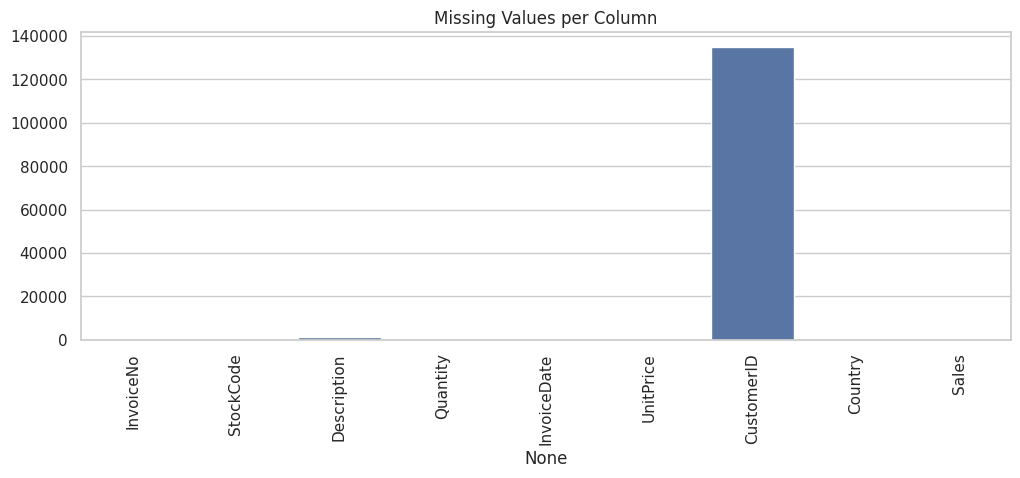

In [4]:
plt.figure(figsize=(12,4))
sns.barplot(x=raw.isna().sum().index, y=raw.isna().sum().values)
plt.xticks(rotation=90)
plt.title("Missing Values per Column")
plt.show()


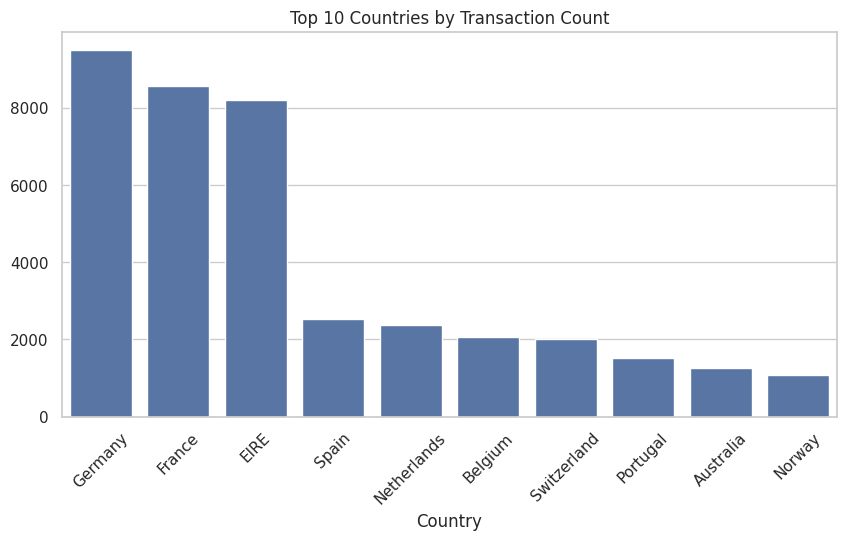

In [5]:
top_countries = (
    raw[raw["Country"] != "United Kingdom"]["Country"]
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 Countries by Transaction Count")
plt.xticks(rotation=45)
plt.show()


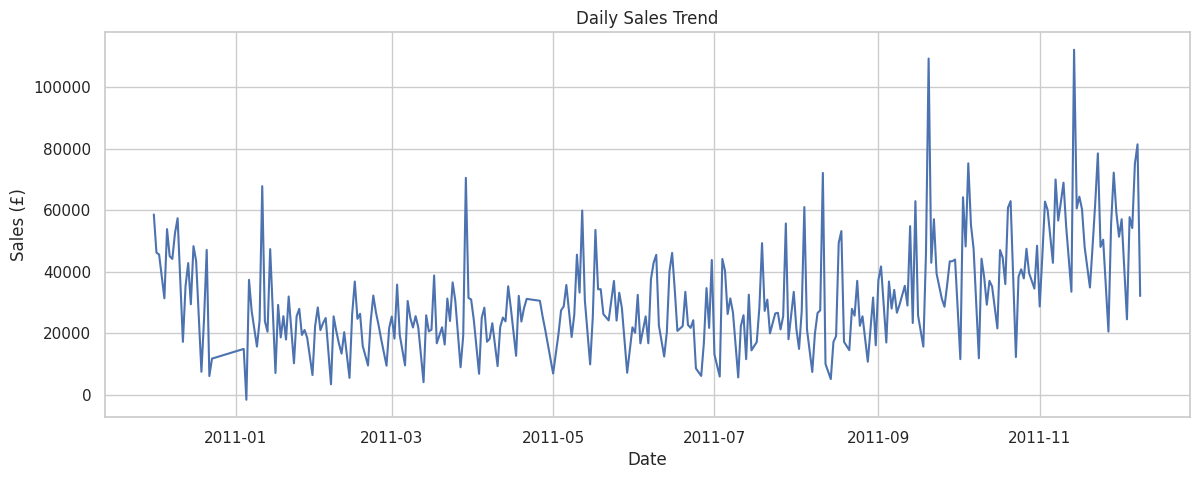

In [6]:
daily_sales = raw.groupby(raw["InvoiceDate"].dt.date)["Sales"].sum()

plt.figure(figsize=(14,5))
plt.plot(daily_sales.index, daily_sales.values)
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales (£)")
plt.grid(True)
plt.show()


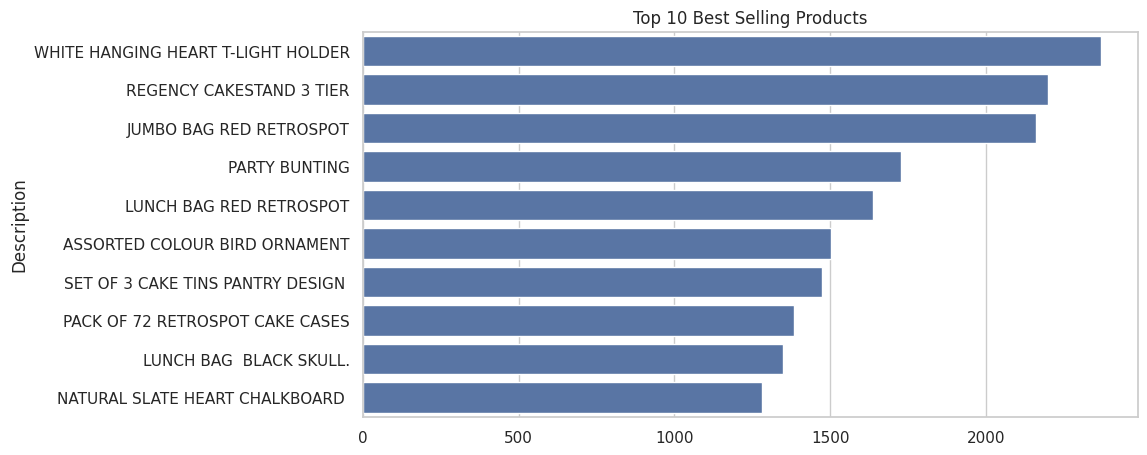

In [7]:
top_products = raw["Description"].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(y=top_products.index, x=top_products.values)
plt.title("Top 10 Best Selling Products")
plt.show()


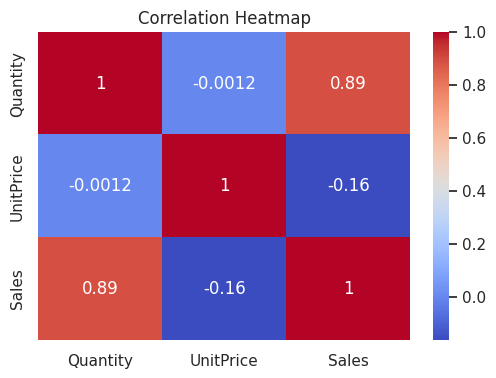

In [8]:
plt.figure(figsize=(6,4))
sns.heatmap(raw[["Quantity","UnitPrice","Sales"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [9]:
def clean_raw_data(df):
    df = df.dropna(subset=["CustomerID", "Description"])
    df = df[df["Quantity"] > 0]
    df = df[df["UnitPrice"] > 0]
    return df

clean = clean_raw_data(raw)
clean.shape


(397884, 9)

In [10]:
def build_customer_features(
    df,
    cutoff_date="2011-09-30",
    prediction_start="2011-10-01",
    prediction_end="2011-12-31"
):
    df = df.copy()
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
    df["Sales"] = df["Quantity"] * df["UnitPrice"]

    cutoff_date = pd.to_datetime(cutoff_date)
    prediction_start = pd.to_datetime(prediction_start)
    prediction_end = pd.to_datetime(prediction_end)

    history = df[df["InvoiceDate"] <= cutoff_date]
    future = df[(df["InvoiceDate"] >= prediction_start) &
                (df["InvoiceDate"] <= prediction_end)]

    agg = history.groupby("CustomerID").agg({
        "InvoiceDate": ["min", "max"],
        "InvoiceNo": "nunique",
        "Quantity": "sum",
        "Sales": "sum"
    }).reset_index()

    agg.columns = [
        "CustomerID", "FirstPurchaseDate", "LastPurchaseDate",
        "Frequency", "TotalQuantity", "Monetary"
    ]

    agg["CustomerLifetime"] = (
        agg["LastPurchaseDate"] - agg["FirstPurchaseDate"]
    ).dt.days.clip(lower=0)

    agg["Recency"] = (cutoff_date - agg["LastPurchaseDate"]).dt.days.clip(lower=0)
    agg["AvgBasketSize"] = agg["TotalQuantity"] / agg["Frequency"]

    agg["AvgPurchaseInterval"] = agg["CustomerLifetime"] / (agg["Frequency"] - 1)
    agg["AvgPurchaseInterval"] = agg["AvgPurchaseInterval"].replace([np.inf,-np.inf],np.nan)
    agg["AvgPurchaseInterval"].fillna(agg["CustomerLifetime"], inplace=True)

    future_flag = future.groupby("CustomerID")["InvoiceNo"].nunique().rename("FuturePurchases")
    agg = agg.merge(future_flag, on="CustomerID", how="left")

    agg["FuturePurchases"] = agg["FuturePurchases"].fillna(0)
    agg["Churn"] = (agg["FuturePurchases"] == 0).astype(int)

    return agg

customer_df = build_customer_features(clean)
customer_df.head()


/tmp/ipython-input-2589658632.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  agg["AvgPurchaseInterval"].fillna(agg["CustomerLifetime"], inplace=True)


,CustomerID,FirstPurchaseDate,LastPurchaseDate,Frequency,TotalQuantity,Monetary,CustomerLifetime,Recency,AvgBasketSize,AvgPurchaseInterval,FuturePurchases,Churn
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,1,74215,77183.60,0,254,74215.000000,0.000000,0.0,1
1,12347.0,2010-12-07 14:57:00,2011-08-02 08:48:00,5,1590,2790.86,237,58,318.000000,59.250000,2.0,0
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,4,2341,1797.24,282,4,585.250000,94.000000,0.0,1
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,1,197,334.40,0,239,197.000000,0.000000,0.0,1
4,12352.0,2011-02-16 12:33:00,2011-09-28 14:58:00,7,409,2194.31,224,1,58.428571,37.333333,1.0,0


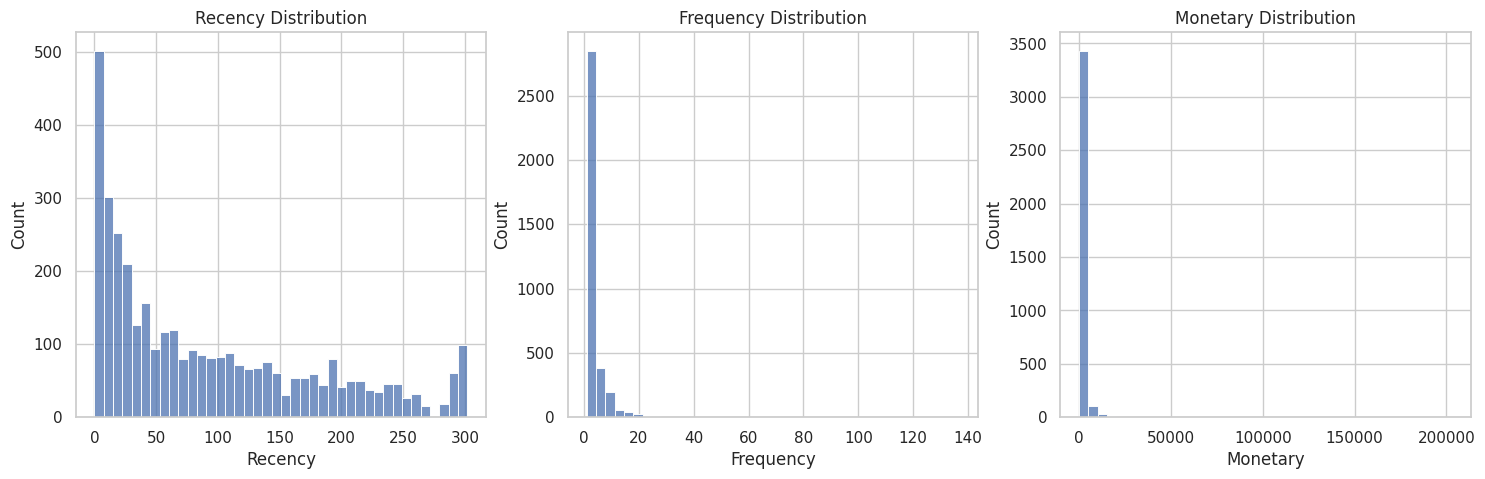

In [11]:
fig, axes = plt.subplots(1,3, figsize=(18,5))

sns.histplot(customer_df["Recency"], bins=40, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(customer_df["Frequency"], bins=40, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(customer_df["Monetary"], bins=40, ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.show()


In [12]:
rfm = customer_df[["Recency","Frequency","Monetary"]]

scaler_rfm = StandardScaler()
rfm_scaled = scaler_rfm.fit_transform(rfm)


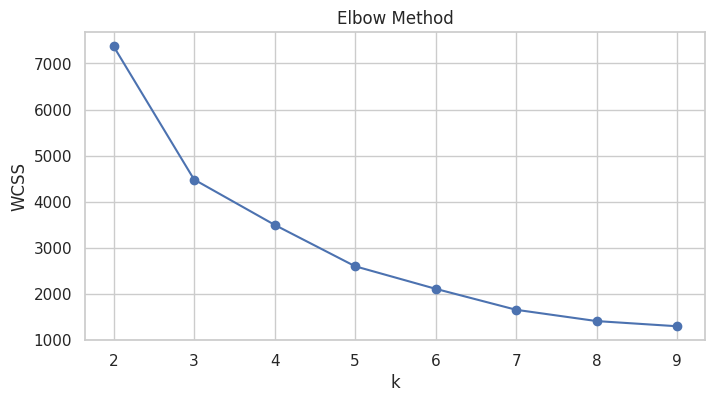

In [13]:
wcss = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(2,10), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.show()


In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df["Cluster"] = kmeans.fit_predict(rfm_scaled)

customer_df.head()


,CustomerID,FirstPurchaseDate,LastPurchaseDate,Frequency,TotalQuantity,Monetary,CustomerLifetime,Recency,AvgBasketSize,AvgPurchaseInterval,FuturePurchases,Churn,Cluster
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,1,74215,77183.60,0,254,74215.000000,0.000000,0.0,1,1
1,12347.0,2010-12-07 14:57:00,2011-08-02 08:48:00,5,1590,2790.86,237,58,318.000000,59.250000,2.0,0,2
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,4,2341,1797.24,282,4,585.250000,94.000000,0.0,1,2
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,1,197,334.40,0,239,197.000000,0.000000,0.0,1,0
4,12352.0,2011-02-16 12:33:00,2011-09-28 14:58:00,7,409,2194.31,224,1,58.428571,37.333333,1.0,0,2


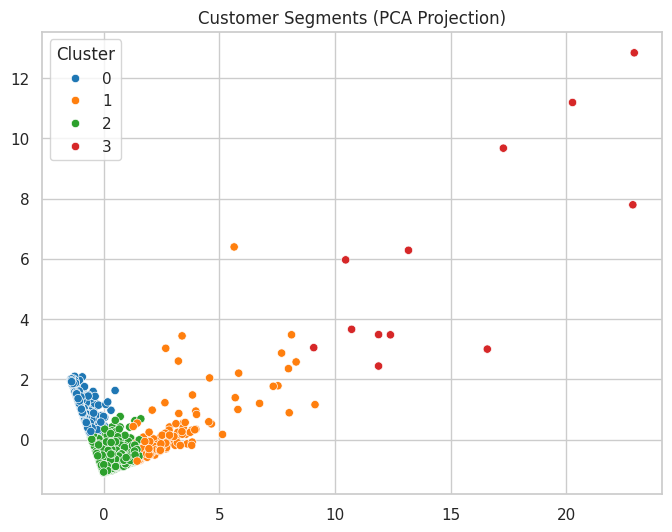

In [15]:
pca = PCA(n_components=2)
pca_comp = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_comp[:,0], y=pca_comp[:,1],
                hue=customer_df["Cluster"], palette="tab10")
plt.title("Customer Segments (PCA Projection)")
plt.show()


In [16]:
FEATURES = [
    "Recency", "Frequency", "Monetary",
    "CustomerLifetime", "AvgBasketSize",
    "AvgPurchaseInterval", "Cluster"
]


In [17]:
def split_and_scale(df):
    X = df[FEATURES]
    y = df["Churn"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    return X_train_s, X_test_s, y_train, y_test, scaler

X_train_s, X_test_s, y_train, y_test, scaler = split_and_scale(customer_df)


In [18]:
def build_models():
    return {
        "log_reg": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "rf": RandomForestClassifier(
            n_estimators=300, min_samples_split=10, min_samples_leaf=5,
            random_state=42, n_jobs=-1
        ),
        "xgb": XGBClassifier(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, eval_metric="logloss"
        )
    }


In [28]:


param_grids = {

    "log_reg": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear", "lbfgs"],
        "class_weight": ["balanced", None]
    },

    "rf": {
        "n_estimators": [100, 300, 500],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5]
    },

    "xgb": {
        "n_estimators": [200, 400],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


In [29]:
results = []
models = build_models()
fitted_models = {}

for name, model in models.items():
    print(f"\n Running GridSearchCV for {name} ...")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring="roc_auc",
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid.fit(X_train_s, y_train)
    best_model = grid.best_estimator_

    fitted_models[name] = best_model

    # Predictions
    y_pred = best_model.predict(X_test_s)
    y_prob = best_model.predict_proba(X_test_s)[:, 1]

    # Metrics
    metrics = {
        "model": name,
        "roc_auc": roc_auc_score(y_test, y_prob),
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }

    results.append(metrics)

results_df = pd.DataFrame(results).set_index("model")
results_df



 Running GridSearchCV for log_reg ...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

 Running GridSearchCV for rf ...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

 Running GridSearchCV for xgb ...
Fitting 3 folds for each of 162 candidates, totalling 486 fits


,roc_auc,accuracy,precision,recall,f1
model,,,,,
log_reg,0.746340,0.680999,0.644860,0.779661,0.705882
rf,0.741329,0.683773,0.674033,0.689266,0.681564
xgb,0.752355,0.704577,0.684073,0.740113,0.710991


In [30]:
for name, model in fitted_models.items():
    print(f"\n Best Parameters for {name}:")
    print(model.get_params())



 Best Parameters for log_reg:
{'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

 Best Parameters for rf:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

 Best Parameters for xgb:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'e

In [31]:
best_model_name = results_df["roc_auc"].idxmax()
best_model = fitted_models[best_model_name]

best_model_name, results_df.loc[best_model_name]


('xgb',
 roc_auc      0.752355
 accuracy     0.704577
 precision    0.684073
 recall       0.740113
 f1           0.710991
 Name: xgb, dtype: float64)

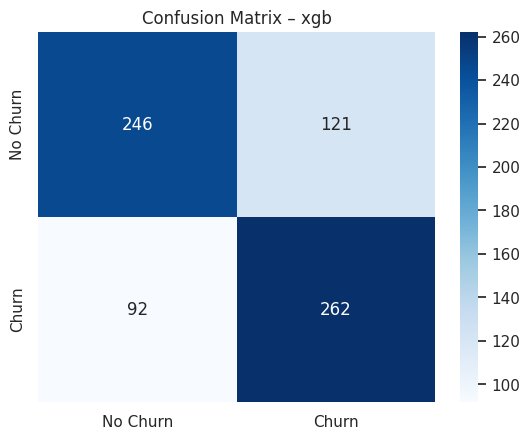

In [32]:
y_pred_best = best_model.predict(X_test_s)
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn","Churn"],
            yticklabels=["No Churn","Churn"])
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()


In [33]:
joblib.dump(best_model, "/content/drive/MyDrive/best_churn_model_1.pkl")
joblib.dump(scaler, "/content/drive/MyDrive/scaler_1.pkl")

print("Saved best_churn_model.pkl and scaler.pkl in google drive")


Saved best_churn_model.pkl and scaler.pkl in google drive
